'DOG' detected with confidence 0.99949491024 in [371.315582275, 66.1026526093, 635.889678955, 550.546167791]
'DOG' detected with confidence 0.998925983906 in [37.305141449, 37.3748987764, 284.00296402, 513.215347186]
'PERSON' detected with confidence 0.811111688614 in [173.379379272, 0.0, 437.561233521, 555.741108656]
'PERSON' detected with confidence 0.802284359932 in [946.293395996, 0.784470511135, 76.2532348633, 456.442427682]
'PERSON' detected with confidence 0.996657013893 in [215.821573973, 699.04358983, 56.7194049358, 159.645456076]
'KITE' detected with confidence 0.995519638062 in [592.524039984, 79.8412419856, 75.4543604851, 72.9901693761]
'PERSON' detected with confidence 0.992294788361 in [115.186678708, 615.607845783, 51.122954905, 143.155986071]
'PERSON' detected with confidence 0.97895604372 in [84.0955817699, 511.919546127, 24.0005417466, 54.2733728886]
'KITE' detected with confidence 0.96934735775 in [279.933185697, 235.64914763, 26.1995482445, 47.5152254105]
'KITE' det

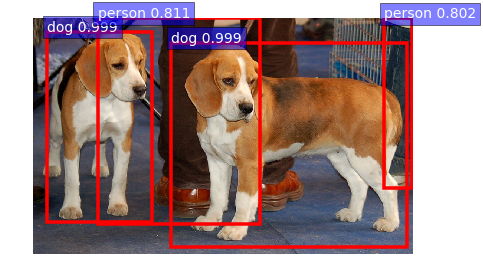

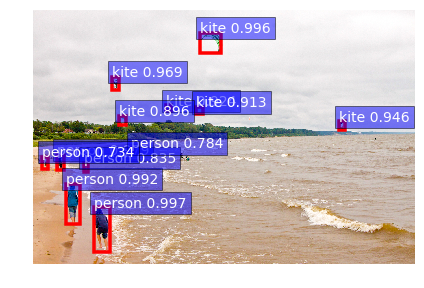

In [23]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from collections import defaultdict
from io import StringIO
from PIL import Image
import time
sys.path.append("..")  #Not sure if I need this line if I run it in the parental directory
from utils import label_map_util

MODELS = ['ssd_mobilenet_v1_coco_11_06_2017', 'ssd_inception_v2_coco_11_06_2017',\
                  'rfcn_resnet101_coco_11_06_2017', 'faster_rcnn_resnet101_coco_11_06_2017',\
                   'faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017']




NUM_CLASSES = 90
PATH_TO_LABELS = "/root/models/object_detection/data/mscoco_label_map.pbtxt"
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


#Get the session from the specified model
def load_model(model, dynamic_memory=True):
    
    #Dynamically allocating memory
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=dynamic_memory
    sess = tf.Session(config=config)    
    PATH_TO_CKPT = os.path.join("/root/models/object_detection", model , 'frozen_inference_graph.pb')
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
            
    return tf.Session(graph=detection_graph, config=config)


def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


def translate_result(boxes, scores, classes, num_detections, im_width, im_height, thresh):
    #Normalizing the detection result
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)    
    
    thresh_mask = scores > thresh
    
    scores = scores[thresh_mask]
    boxes = boxes[thresh_mask]
    classes = classes[thresh_mask]
    
    outputs = []        
    for i, score in enumerate(scores):      
        #Stop when score is lower than threshold since the score is sorted
        #!!!!Performance of this line can be improved!!!！
       

        class_name = category_index[classes[i]]['name']
        ymin, xmin, ymax, xmax = boxes[i]
        left, right, top, bottom = (xmin * im_width, xmax * im_width,\
                                  ymin * im_height, ymax * im_height)          
        #Allocating result into ouput dict
        output = {}        
        output['score'] = score
        output['class'] = class_name
        output['x'] = left
        output['y'] = top
        output['width'] = right-left
        output['height'] = bottom-top
        #Append each detection into a list
        outputs.append(output)
    return outputs


def detect(sess, img_path, thresh=0.7):
    img = Image.open(img_path)
    img_width, img_height = img.size
    img_np = load_image_into_numpy_array(img)
    img_np_expanded = np.expand_dims(img_np, axis=0)
    
    #Initalization of output and input tensors for session
    img_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    scores = sess.graph.get_tensor_by_name('detection_scores:0')
    classes = sess.graph.get_tensor_by_name('detection_classes:0')
    num_detections = sess.graph.get_tensor_by_name('num_detections:0')
    
    outputs = [boxes, scores, classes, num_detections]
    feed_dict = {img_tensor: img_np_expanded}
    boxes, scores, classes, num_detections = sess.run(outputs,feed_dict=feed_dict) 
 
    return translate_result(boxes, scores, classes, num_detections, img_width,\
                            img_height,thresh)
    
if __name__ == "__main__":
    TEST_IMAGE_PATHS = [os.path.join("/root/models/object_detection/test_images",\
                                     'image{}.jpg'.format(i)) for i in range(1,3)]
    THRESHOLD = 0.7
    model = MODELS[3]
    sess = load_model(model)
    for img_path in TEST_IMAGE_PATHS:
        result = detect(sess, img_path, thresh=THRESHOLD)
        outputs = result
        for output in outputs:                     
            score = output['score'] 
            class_name = output['class']
            x = output['x']
            y = output['y']
            width = output['width']
            height = output['height']                       
            print("'{}' detected with confidence {} in [{}, {}, {}, {}]".format(class_name.upper(),\
                                                                              score, x, y, width,\
                                                                              height)) 
        vis_detections(img_path, outputs)

In [11]:
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

In [19]:

def vis_detections(img_path, outputs):
    """Draw detected bounding boxes."""
    im = cv2.imread(img_path)
    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(im, aspect='equal')
    
    for output in outputs:
        score = output['score'] 
        class_name = output['class']
        x = output['x']
        y = output['y']
        width = output['width']
        height = output['height']   
      

        ax.add_patch(
            plt.Rectangle((x, y),
                          width,
                          height, fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(x, y - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')


    plt.axis('off')
    plt.tight_layout()
    plt.draw()


In [21]:
categories

[{'id': 1, 'name': u'person'},
 {'id': 2, 'name': u'bicycle'},
 {'id': 3, 'name': u'car'},
 {'id': 4, 'name': u'motorcycle'},
 {'id': 5, 'name': u'airplane'},
 {'id': 6, 'name': u'bus'},
 {'id': 7, 'name': u'train'},
 {'id': 8, 'name': u'truck'},
 {'id': 9, 'name': u'boat'},
 {'id': 10, 'name': u'traffic light'},
 {'id': 11, 'name': u'fire hydrant'},
 {'id': 13, 'name': u'stop sign'},
 {'id': 14, 'name': u'parking meter'},
 {'id': 15, 'name': u'bench'},
 {'id': 16, 'name': u'bird'},
 {'id': 17, 'name': u'cat'},
 {'id': 18, 'name': u'dog'},
 {'id': 19, 'name': u'horse'},
 {'id': 20, 'name': u'sheep'},
 {'id': 21, 'name': u'cow'},
 {'id': 22, 'name': u'elephant'},
 {'id': 23, 'name': u'bear'},
 {'id': 24, 'name': u'zebra'},
 {'id': 25, 'name': u'giraffe'},
 {'id': 27, 'name': u'backpack'},
 {'id': 28, 'name': u'umbrella'},
 {'id': 31, 'name': u'handbag'},
 {'id': 32, 'name': u'tie'},
 {'id': 33, 'name': u'suitcase'},
 {'id': 34, 'name': u'frisbee'},
 {'id': 35, 'name': u'skis'},
 {'id': 